In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-generator/data_generator.py
/kaggle/input/generator/data_generator.py


In [2]:
#ExpansionNet_v2
#CNNs+LSTM

In [3]:
!pip install opendatasets -q
!pip install rouge_score -q

In [4]:
import opendatasets as od
import random
import re
import torch
import torch.nn as nn
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# from transformers import BertTokenizer, BertForMaskedLM
# from transformers import DistilBertModel, DistilBertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
from transformers import XLMRobertaTokenizer, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split

from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import os
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [6]:
od.download("https://www.kaggle.com/datasets/ttony0321/imagesam")
##

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ttony0321


Your Kaggle Key:

  ································


100%|██████████| 7.20G/7.20G [05:42<00:00, 22.6MB/s]  


In [9]:
train_path = '/kaggle/working/imagesam/train.csv'
test_path = '/kaggle/working/imagesam/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [10]:
image_path = '/kaggle/working/imagesam/train'

In [11]:
train['img_path'] = train['img_path'].str.replace('./train/', '/kaggle/working/imagesam/train/')
test['img_path'] = test['img_path'].str.replace('./test/', '/kaggle/working/imagesam/test/')

In [12]:
train.head()

,img_name,img_path,mos,comments
0,41wy7upxzl,/kaggle/working/imagesam/train/41wy7upxzl.jpg,5.569231,the pink and blue really compliment each other...
1,ygujjq6xxt,/kaggle/working/imagesam/train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,/kaggle/working/imagesam/train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. ...
3,w50dp2zjpg,/kaggle/working/imagesam/train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, ..."
4,l7rqfxeuh0,/kaggle/working/imagesam/train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a litt..."


In [13]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [14]:
train['comments'] = train['comments'].apply(preprocess)
train.head()

,img_name,img_path,mos,comments
0,41wy7upxzl,/kaggle/working/imagesam/train/41wy7upxzl.jpg,5.569231,[start] the pink and blue really compliment ea...
1,ygujjq6xxt,/kaggle/working/imagesam/train/ygujjq6xxt.jpg,6.103175,[start] love rhubarb great colors [end]
2,wk321130q0,/kaggle/working/imagesam/train/wk321130q0.jpg,5.541985,[start] i enjoy the textures and grungy feel t...
3,w50dp2zjpg,/kaggle/working/imagesam/train/w50dp2zjpg.jpg,6.234848,[start] i like all the different colours in th...
4,l7rqfxeuh0,/kaggle/working/imagesam/train/l7rqfxeuh0.jpg,5.190476,[start] i love these critters just wish he was...


[start] conveys the meaning well bit overexposed on the highlights but good [end]



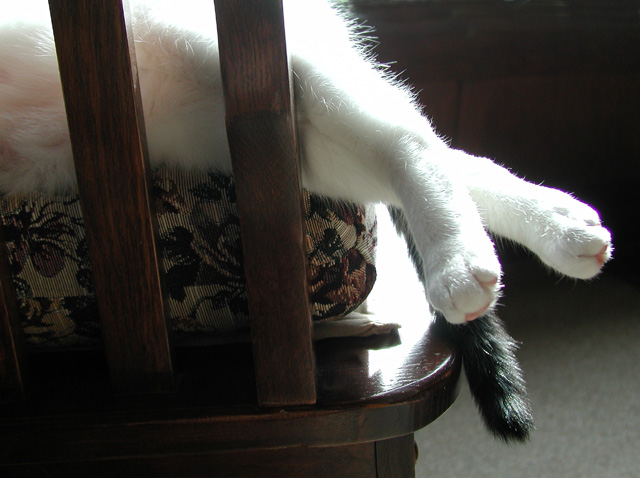

In [15]:
random_row = train.sample(1).iloc[0]
print(random_row.comments)
print()
im = Image.open(random_row.img_path)
im

In [43]:
MAX_LENGTH = 50
VOCABULARY_SIZE = 55555
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 15

In [44]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(train['comments'])

In [45]:
tokenizer.vocabulary_size()

29004

In [47]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [48]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [49]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(train['img_path'], train['comments']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [50]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)


(59702, 59702, 14866, 14866)

In [51]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [56]:
new_height = 225
new_width = 225

In [59]:
image_augmentation = tf.keras.Sequential(
    [
        
        tf.keras.layers.Resizing(height=new_height, width=new_width),  # Resize the image
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
        tf.keras.layers.Rescaling(1./255),  # Normalize pixel values to [0,1]
    ]
)

In [60]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [61]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [62]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [63]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [64]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [65]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [66]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [67]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:36 - loss: 6.1044 - acc: 0.0659

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 48s - loss: 6.0425 - acc: 0.0668

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 332s 339ms/step - loss: 6.0258 - acc: 0.0671 - val_loss: 5.8873 - val_acc: 0.0806
Epoch 2/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:19 - loss: 5.7188 - acc: 0.0861

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 5.6662 - acc: 0.0910

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 299s 318ms/step - loss: 5.6325 - acc: 0.0934 - val_loss: 5.4291 - val_acc: 0.1359
Epoch 3/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:19 - loss: 5.2039 - acc: 0.1440

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 5.0815 - acc: 0.1518

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 298s 317ms/step - loss: 5.2095 - acc: 0.1535 - val_loss: 5.4959 - val_acc: 0.1236
Epoch 4/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:19 - loss: 4.8861 - acc: 0.1736

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 4.7995 - acc: 0.1839

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 300s 320ms/step - loss: 4.7814 - acc: 0.1871 - val_loss: 4.9069 - val_acc: 0.2040
Epoch 5/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:18 - loss: 4.5742 - acc: 0.2212

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 4.5396 - acc: 0.2230

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 298s 317ms/step - loss: 4.5330 - acc: 0.2238 - val_loss: 4.7096 - val_acc: 0.2204
Epoch 6/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


393/933 [===========>..................] - ETA: 2:19 - loss: 4.4032 - acc: 0.2384

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


756/933 [=======================>......] - ETA: 45s - loss: 4.3791 - acc: 0.2399

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 298s 318ms/step - loss: 4.3751 - acc: 0.2405 - val_loss: 4.6616 - val_acc: 0.2297
Epoch 7/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:19 - loss: 4.2757 - acc: 0.2506

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 4.2523 - acc: 0.2519

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 298s 317ms/step - loss: 4.2477 - acc: 0.2524 - val_loss: 4.6326 - val_acc: 0.2352
Epoch 8/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:18 - loss: 4.1601 - acc: 0.2609

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 4.1409 - acc: 0.2622

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 297s 317ms/step - loss: 4.1368 - acc: 0.2627 - val_loss: 4.6344 - val_acc: 0.2367
Epoch 9/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:18 - loss: 4.0567 - acc: 0.2706

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


757/933 [=======================>......] - ETA: 45s - loss: 4.0388 - acc: 0.2719

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 297s 317ms/step - loss: 4.0359 - acc: 0.2723 - val_loss: 4.6381 - val_acc: 0.2424
Epoch 10/15


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


394/933 [===========>..................] - ETA: 2:19 - loss: 3.9646 - acc: 0.2801

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


756/933 [=======================>......] - ETA: 45s - loss: 3.9472 - acc: 0.2812

Corrupt JPEG data: 646 extraneous bytes before marker 0xd9
Corrupt JPEG data: 646 extraneous bytes before marker 0xd9


933/933 [==============================] - 300s 320ms/step - loss: 3.9448 - acc: 0.2815 - val_loss: 4.6672 - val_acc: 0.2408


In [78]:
#caption_model.save("/kaggle/working/imagesam/model.pt")
caption_model.save_weights("/kaggle/working/imagesam/model.h5")
#loaded_model = tf.keras.models.load_model("/kaggle/working/imagesam")


In [177]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

/kaggle/working/imagesam/train/wnr12t2ie4.jpg
Predicted Caption: i like the colors and the colors are very nice



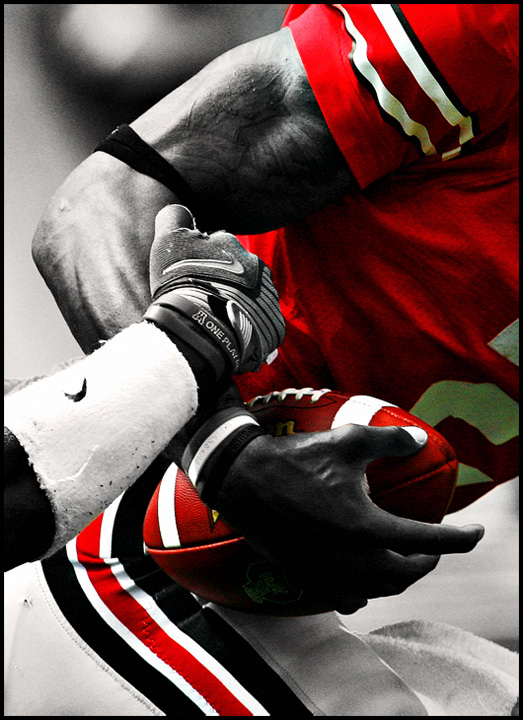

In [179]:
idx = random.randrange(0, len(train))
img_path = train.iloc[idx].img_path
print(img_path)
pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: i like the colors and the colors are very nice



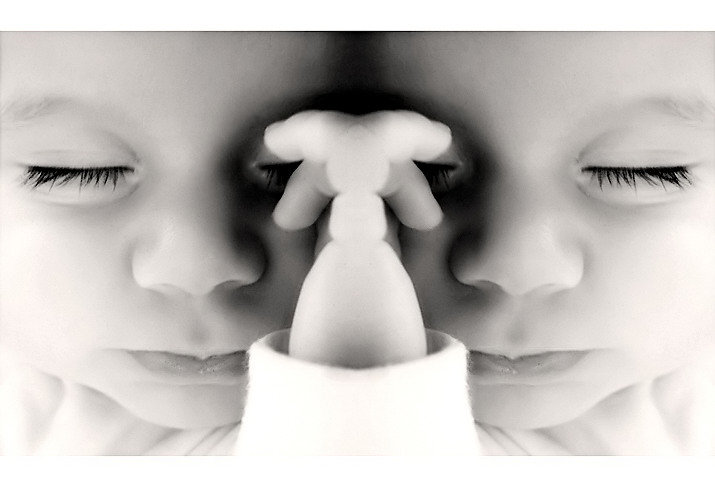

In [183]:
idx = random.randrange(0, len(train))
img_path = train.iloc[idx].img_path

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)